# Segment and quantify puncta (Setup)

This is a setup notebook for adjusting parameters for [run_puncta_analysis.ipynb](run_puncta_analysis.ipynb).

Run this notebook cell-by-cell and follow the instructions.

## Documentation

[Details of the puncta segmentation procedure](../docs/puncta_segmentation.md)

[Table summarizing all parameters that are adjusted in this notebook](../docs/parameters.md#list-of-parameters-for-puncta-segmentation-and-analysis)


## Requirements

- A **folder with images** to analyze. All z-layers and channels for a specific sample must be combined into a single file. To combine z-layers and channels, use the [setup_images_to_stack.ipynb](setup_images_to_stack.ipynb) and [run_images_to_stack.ipynb](run_images_to_stack.ipynb) notebooks.

or 

- A  **folder with images** generated by [run_roi_segmentation.ipynb](run_roi_segmentation.ipynb) or [run_roi_segmentation.py](../scripts/run_roi_segmentation.py); the images must contain raw image channels + ROI segmentation mask

<hr style="height:2px;">

## Config

<hr style="height:2px;">

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import json
import os
import numpy as np
import intake_io
from skimage.feature import blob_log
from skimage.segmentation import watershed
from scipy import ndimage
import pylab as plt

from am_utils.utils import walk_dir
from punctatools.lib.segment import calculate_background_image, centers_to_markers, threshold_puncta;
from punctatools.lib.utils import show_dataset, show_imgs, display_blobs
from punctatools.lib.utils import crop_dataset, convert_params

%matplotlib inline

2022-06-17 16:30:54,309 [INFO] WRITING LOG OUTPUT TO /home/amedyukh/.cellpose/run.log



<hr style="height:2px;">

## Set up the data to segment

<hr style="height:2px;">

`input_dir`: A folder with images to analyze. If ROI segmentation was done, set this to the `output_dir` of the ROI segmentation. 

`roi_segmentation`: Set to `True` if the ROI segmentation was done and the last channel of the images in the `input_dir` contains the segmentation mask

`output_dir`: output directory for the puncta analysis results

In [2]:
input_dir = "../example_data/stacks"
roi_segmentation = False
output_dir = "../test_output/puncta_analysis"

### The following code lists all image files in the input directory:

In [3]:
#################################
#  Don't modify the code below  #
#################################

print(rf"Input directory: {input_dir}")
if not roi_segmentation:
    print('No cell segmentation provided')
samples = walk_dir(input_dir)

print(f'\n{len(samples)} images were found:')
for i in range(len(samples)):
    print(i, samples[i])

Input directory: ../example_data/stacks
No cell segmentation provided

2 images were found:
0 ../example_data/stacks/sample1_position1.tif
1 ../example_data/stacks/sample1_position2.tif


<hr style="height:0.5px;">

### Please provide the index of the sample to analyze:

Set to `None` to select a random image

In [4]:
sample_index = 0

### The following code loads and displays a random image

<xarray.Dataset>
Dimensions:  (y: 326, x: 326, z: 5, c: 3)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8
Dimensions without coordinates: c
Data variables:
    image    (c, z, y, x) uint16 105 106 103 110 106 113 ... 101 102 100 102 100
Attributes:
    metadata:  {'spacing_units': {'z': 'µm', 'y': 'µm', 'x': 'µm'}} 

Number of channels: 3


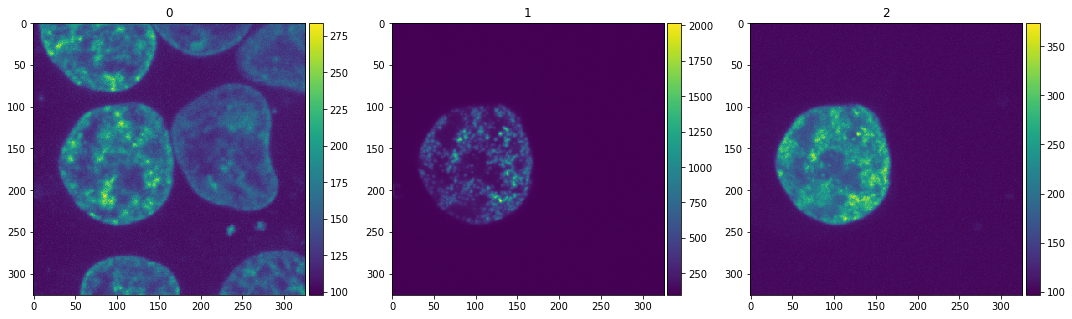

In [5]:
#################################
#  Don't modify the code below  #
#################################

if sample_index is None:
    sample_index = np.random.randint(len(samples))
    
sample = samples[sample_index]
dataset = intake_io.imload(sample)
print(dataset, '\n')
if 'c' in dataset.dims:
    nchannels = len(dataset['c'].data)
else:
    nchannels = 1
if roi_segmentation:
    nchannels -= 1
print(rf"Number of channels: {nchannels}")

show_dataset(dataset)

<hr style="height:0.5px;">

### Please specify the indices of puncta channels and the channel to set up


`puncta_channels` : list of channel indices, starting form 0, that should be used to segment puncta. 

**Examples**:

`puncta_channels = [1]` : puncta will be segmented in the second channel

`puncta_channels = [2, 3]` : puncta will be segmented in the third and fourth channels


In [6]:
puncta_channels = [1, 2]

### The following code displays the puncta channels and the nuclei segmentation of the current image

Current number of z layers: 5


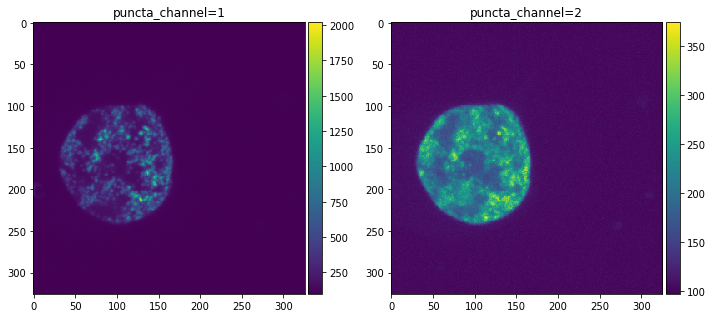

In [7]:
#################################
#  Don't modify the code below  #
#################################

if 'z' in dataset.dims:
    print(rf'Current number of z layers: {len(dataset["z"].data)}')
else:
    print('No z layers were found, the dataset is 2D')
    
channel_names = [rf"puncta_channel={i}" for i in puncta_channels]
    
if roi_segmentation:
    show_dataset(dataset, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(dataset, puncta_channels, channel_names)
    

### Please select a small box to test the analysis:

Keep the width and height 200 - 500 pixels.

To used the entire image, set x, y, z, width, height and depth to `None`

In [8]:
x = 0    # coordinate of the left border
y = 70   # coordinate of the top border
z = 0
width = 200   # width of the box
height = 200  # height of the box
depth = 5

### The following code crops the dataset and displays the cropped area:

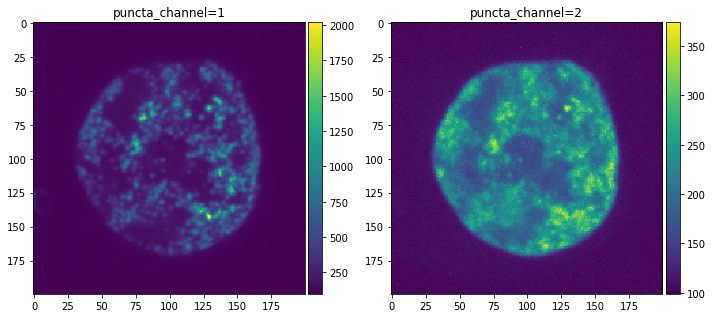

In [9]:
#################################
#  Don't modify the code below  #
#################################

ds_crop = crop_dataset(dataset, x, y, z, width, height, depth)

if roi_segmentation:
    show_dataset(ds_crop, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(ds_crop, puncta_channels, channel_names)


<hr style="height:2px;">

## Set up puncta detection

<hr style="height:2px;">

The following are the steps to set up for the puncta detection. At each step, you will be asked to set up the corresponding parameters.

1. Detect puncta centers
2. Filter out centers based on their intensity relative to the background. 
3. Segment puncta masks from the background
4. Remove large puncta and puncta outside cells/nuclei


<hr style="height:0.5px;">

### Please specify parameters for detection of puncta centers

The candidate puncta centers are detected using the Laplacian of Gaussian (LoG) blob detector.

You can specify one value or a list for each parameter. If one value is provided, the same value will be used for all channels. Provide a list if different values should be used for different puncta channels. The length of the list should be equal to the number of puncta channels.

#### Frequent:

`minsize_um`: miminum target puncta size (microns); default is 0.2

`maxsize_um`: maximum target puncta size (microns); default is 2

`threshold_detection`: threshold used by the LoG detector to exclude low intensity centers. Reduce this to detect blobs with lower intensities. Should be close to 0 and can be both positive and negative.

#### Advanced:

`num_sigma`: number of sigma values for the LoG detector; default is 5

`overlap`: a value between 0 and 1; parameter used by the LoG detector to remove the smaller one of two overlapping blobs

<hr style="height:0.5px;">

#### Tips for parameter adjustment:

Start with very low value of `threshold_detection` (e.g. 0), and adjust `minsize_um` and `maxsize_um` to make sure that all puncta of relevant size are detected. After that, gradually increase the value of `threshold_detection` to remove low intensity centers.


In [10]:
# frequent:
minsize_um = 0.2  
maxsize_um = 2  
threshold_detection = [0.001, 0.0001] 

# advanced:
num_sigma = 5
overlap = 1

### The following code detects puncta centers and shows results

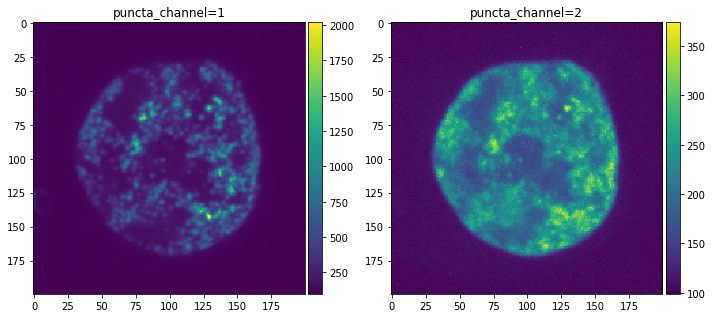

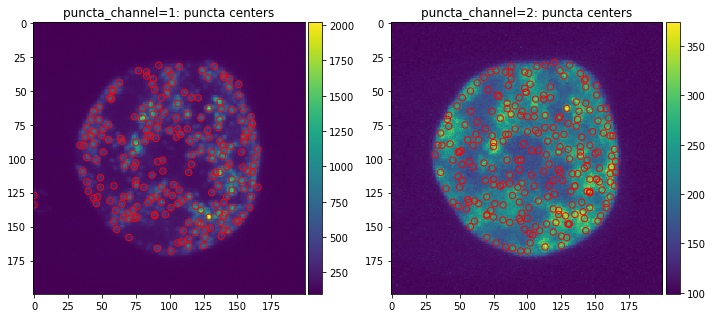

In [11]:
#################################
#  Don't modify the code below  #
#################################

spacing = np.array(intake_io.get_spacing(dataset))
if 'c' in ds_crop.dims:
    chnames = ds_crop['c'].data
else:
    chnames = [0]
imgs = []

logblobs_all = []
for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    minsize_um2, maxsize_um2, threshold_detection2, num_sigma2, overlap2 = convert_params(len(puncta_channels), 
                                                                                          i,
                                                                                          minsize_um, maxsize_um, 
                                                                                          threshold_detection, 
                                                                                          num_sigma, overlap)
    if 'c' in ds_crop.dims:
        img = ds_crop.loc[dict(c=chnames[current_channel])]['image'].data
    else:
        img = ds_crop['image'].data
    imgs.append(img)

    # find blob centers with scale-adapted LoG
    logblobs = blob_log(img,
                        min_sigma=minsize_um2 / spacing,
                        max_sigma=maxsize_um2 / spacing,
                        num_sigma=int(num_sigma2),
                        overlap=overlap2,
                        threshold=threshold_detection2)
    logblobs_all.append(logblobs)

show_dataset(ds_crop, puncta_channels, channel_names)
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)] for logblobs in logblobs_all], 
              puncta_channels, channel_names, 'puncta centers')

### Please specify parameters for background filtering

Low intensity puncta centers can be additionally filtered out based on there intensity relative to the background.

**Important**: This step requires ROI segmentation for calculating the background. Without ROI segmentation, this step will not have any effect.

You can specify one value or a list for each parameter. If one value is provided, the same value will be used for all channels. Provide a list if different values should be used for different puncta channels. The length of the list should be equal to the number of puncta channels.

#### Frequent:

`threshold_background`: threshold used to remove low intensity puncta centers, provided relative to the ROI background value (see “background_percentile”); example: `threshold_ background=3` will remove all puncta centers with fluorescent intensity lower than 3 background values; set to 0 to keep all puncta centers.

`global_background`: If `True`, the background value is calculated globally as the `global_background_percentile` of all ROI; set to `False` if there is a large range of cell fluorescence values:  this will increase sensitivity in cells with low fluorescence and decrease sensitivity in cells with high fluorescence


#### Advanced:

`background_percentile`: Percentile (between 0 and 100) of image intensity inside ROI used to calculate the background value. Default is 50 (median).

`global_background_percentile`: Percentile (between 0 and 100) of ROI background values used to calculate the global background value. Default is 95.


In [12]:
# frequent:
threshold_background = [2, 1.5]
global_background = False

# advanced:
background_percentile = 50
global_background_percentile = 95

### The following code filters puncta centers based on their intensity relative to the background

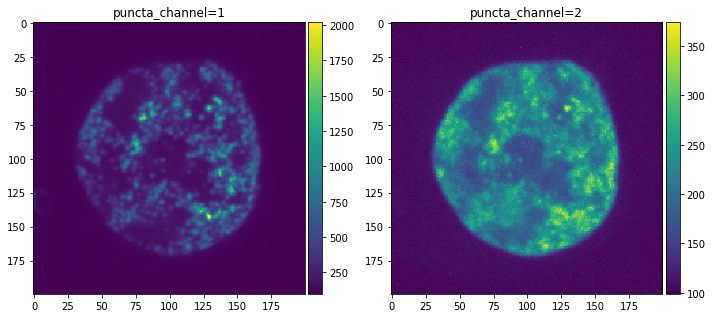

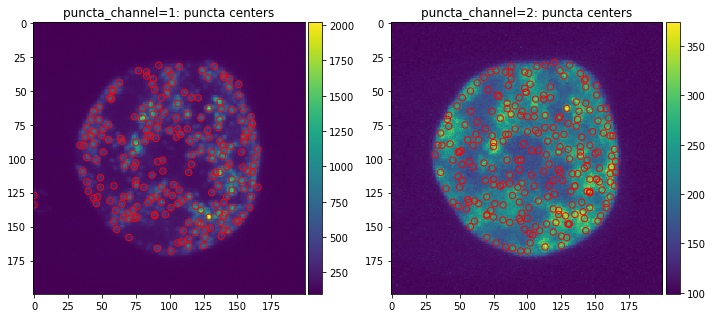

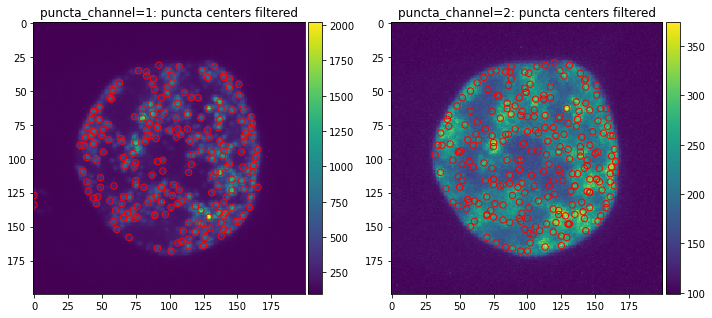

In [13]:
#################################
#  Don't modify the code below  #
#################################

if roi_segmentation:
    roi = ds_crop.loc[dict(c=chnames[-1])]['image'].data
else:
    roi = np.ones_like(imgs[0])
bg_imgs = []
new_centers = []
markers_all = []

for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]

    threshold_background2, global_background2, \
    background_percentile2, global_background_percentile2 = convert_params(len(puncta_channels), i,
                                                                          threshold_background, 
                                                                          global_background, 
                                                                          background_percentile, 
                                                                          global_background_percentile)

    # calculate background image
    bg_img = calculate_background_image(imgs[i], roi, global_background2,
                                        global_background_percentile2, background_percentile2)
    bg_imgs.append(bg_img)

    # convert the blob centers to watershed markers, filter by background
    markers = centers_to_markers(logblobs_all[i], imgs[i], bg_img, threshold_background2)
    markers_all.append(markers)

    # find blob centers with scale-adapted LoG
    new_centers.append(np.array(ndimage.center_of_mass(markers, markers, np.unique(markers)[1:])))

show_dataset(ds_crop, puncta_channels, channel_names)
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)] for logblobs in logblobs_all], 
              puncta_channels, channel_names, 'puncta centers')
display_blobs(ds_crop, new_centers, puncta_channels, channel_names, 'puncta centers filtered')


### Please specify parameters for puncta segmentation 

This step segments puncta from the background.

You can specify one value or a list for each parameter. If one value is provided, the same value will be used for all channels. Provide a list if different values should be used for different puncta channels. The length of the list should be equal to the number of puncta channels.

`threshold_segmentation`: Threshold for puncta segmentation. The way the threshold is applied is determined by `segmentation_mode`. For mode 0, choose values in the order of 0.001; for mode 1, choose values in the order of 50; for mode 2, choose values in the order of 3. Reduce to detect more/larger puncta, increase to detect fewer/smaller puncta

`segmentation_mode`: 0, 1, or 2. Determines the way how `threshold_segmentation` is applied; 0: apply absolute threshold in LoG space; 1: apply threshold relative to background in LoG space; 2: apply threshold relative to the background in image intensity space. Note: mode 1 and 2 will only work if ROI segmentation is available, as it need background calculation.

#### Tips for parameter adjustment:

If no cell / nuclei segmentations are available, set the `segmentation_mode` to 0 and the `threshold_segmentation` between 0.001 and 0.003. Decrease the threshold to detect more/larger puncta, increase to detect fewer/smaller puncta.

If cell or nuclei segmentation is availabe, you may want to try `segmentation_mode` 1. It is more sensitive to low-intensity puncta. Start with `threshold_segmentation` values between 20 and 100. Decrease the threshold to detect more/larger puncta, increase to detect fewer/smaller puncta.

If the contrast between the puncta and the background is very high and the background is homogeneous, you may want to try `segmentation_mode` 2, which segments puncta based on their original fluorescent intensity (versus LoG filtered results in mode 0 and 1). Start with `threshold_segmentation` values between 2 and 3. Decrease the threshold to detect more/larger puncta, increase to detect fewer/smaller puncta.


In [14]:
threshold_segmentation = [0.001, 0.0003]
segmentation_mode = 0

### The following code segments pucnta

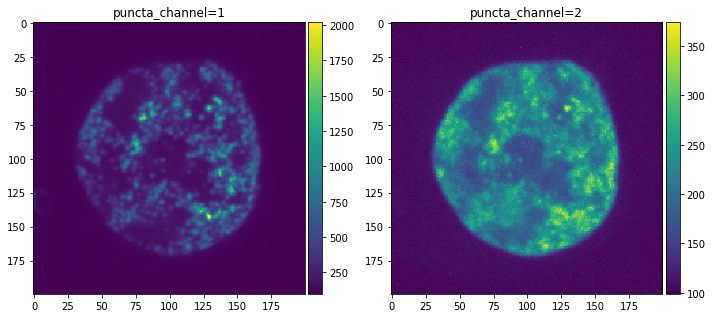

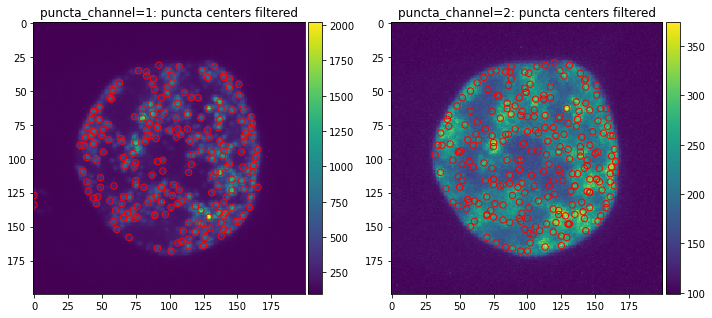

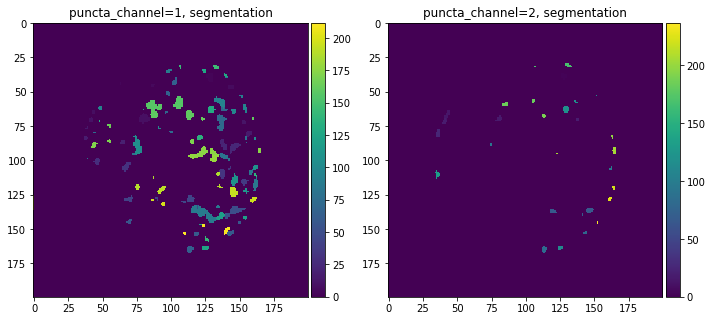

In [15]:
#################################
#  Don't modify the code below  #
#################################

puncta_prelim = []
masks = []

for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    threshold_segmentation2, segmentation_mode2 = convert_params(len(puncta_channels), i,
                                                                 threshold_segmentation, segmentation_mode)

    mask = threshold_puncta(imgs[i], bg_imgs[i], roi, minsize_um2, maxsize_um2, num_sigma2, spacing,
                                segmentation_mode2, threshold_segmentation2)
    masks.append(mask)
    dist = ndimage.distance_transform_edt(mask, sampling=tuple(spacing))
    puncta_prelim.append(watershed(-dist, markers_all[i], mask=mask))

    
show_dataset(ds_crop, puncta_channels, channel_names)
display_blobs(ds_crop, new_centers, puncta_channels, channel_names, 'puncta centers filtered')
show_imgs(puncta_prelim, [chname + ', segmentation' for chname in channel_names])

### Please specify parameters for puncta postprocessing 

`remove_out_of_roi`: If True, puncta (parts) that extend beyond cells/nuclei will be removed. If False, all puncta will be kept.

`maxrad_um`: maximum puncta radius in microns; used to remove large puncta. Set to `None` to keep all segmented puncta.


In [16]:
remove_out_of_roi = False
maxrad_um = None

### The following code removes large puncta and puncta (parts) that are out of cells

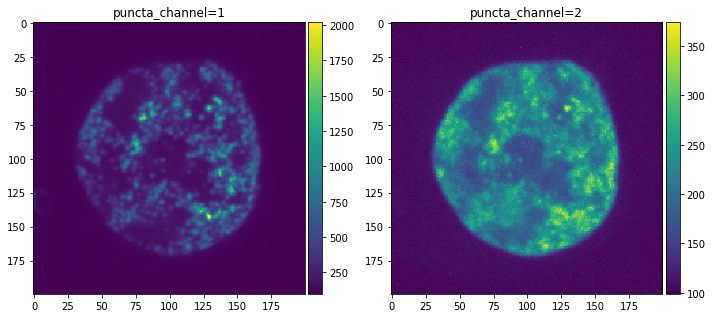

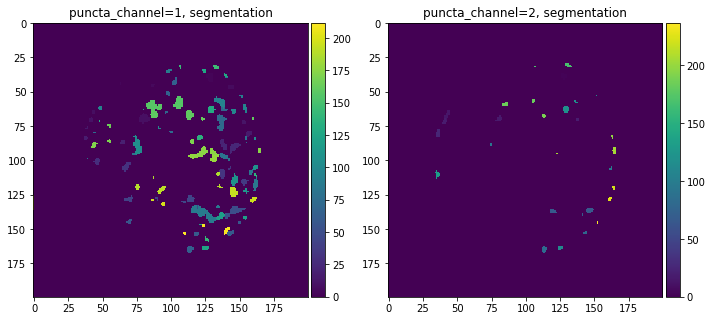

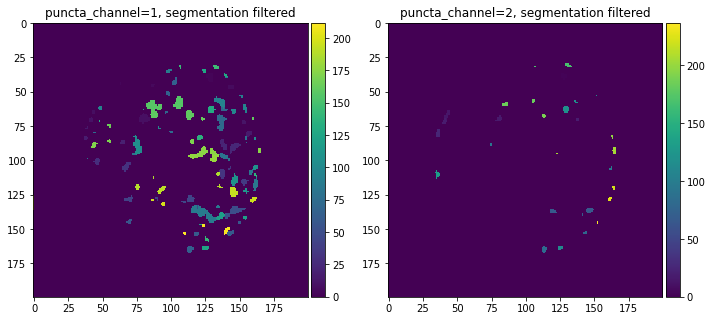

In [17]:
#################################
#  Don't modify the code below  #
#################################

puncta_all = []

for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    
    remove_out_of_roi2, maxrad_um2  = convert_params(len(puncta_channels), i,
                                                      remove_out_of_roi, maxrad_um)
    puncta = masks[i].copy()
    
    if remove_out_of_roi2 and roi is not None:
        puncta = puncta * (roi > 0)


    dist = ndimage.distance_transform_edt(puncta, sampling=tuple(spacing))
    puncta = watershed(-dist, markers_all[i], mask=puncta)
    if maxrad_um is not None:
        llist = np.unique(puncta)
        vol = ndimage.sum(puncta > 0, puncta, llist) * np.prod(spacing)
        maxvol = 4. / 3 * np.pi * maxrad_um2 ** 3
        ix = np.in1d(puncta.ravel(), llist[vol > maxvol]).reshape(puncta.shape)
        puncta[ix] = 0
    puncta_all.append(puncta)

show_dataset(ds_crop, puncta_channels, channel_names)
show_imgs(puncta_prelim, [chname + ', segmentation' for chname in channel_names])
show_imgs(puncta_all, [chname + ', segmentation filtered' for chname in channel_names])

<hr style="height:2px;">

## Run the full processing

The parameters set up in this notebook will be used to segment images in batch.

<hr style="height:2px;">

### Please provide the file name to save the parameters

If only a filename is provided, the parameter file will be saved in the same directory with this notebook. Provide the full path to save the parameters to a different directory.

Default is `parameters_puncta.json`

In [18]:
parameter_file = 'parameters_puncta.json'

### Please specify the list of channel names 

The length of the list must match the number of channels in the original images. These provided names will be used to name the intensity measurments in the outputs of the analysis.

In [19]:
channel_names = ['ch0', 'ch1', 'ch3']

### The following code checks the validity of the list of channels

In [20]:
#################################
#  Don't modify the code below  #
#################################

if len(channel_names) == nchannels:
    print("The list of channel names is valid")
else:
    print(rf"The dataset contains {nchannels} channel, but {len(channel_names)} names were provided. "\
          rf"Please provide {nchannels} names")

The list of channel names is valid


<hr style="height:0.5px;">


### Please specify the names for the puncta analysis outputs

These names will be used to name the output directories and files of the analysis.

`puncta_segm_dir`: subdirectory to store segmented puncta masks (added as extra channel(s) to the input data)

`puncta_quant_dir`: subdirectory to store measurements for individual puncta

`roi_quant_dir`: subdirectory to store measurements for individual ROI (nuclei, cells)

In [21]:
puncta_segm_dir = 'puncta_segm'
puncta_quant_dir = 'puncta_quants'
roi_quant_dir = 'cell_quants'

### The following code saves the parameters

To run the full processing, run the notebook [run_puncta_analysis.ipynb](run_puncta_analysis.ipynb) with the parameter values identified here.


Alternatively run the [run_puncta_analysis.py](../scripts/run_puncta_analysis.py) script:

``python run_puncta_analysis.py -p <parameter_file> -j <number of parallel processes> -i <input directory> -o <output directory>``

In [22]:
#################################
#  Don't modify the code below  #
#################################

params = dict(
    input_dir=os.path.realpath(input_dir),
    output_dir=os.path.realpath(output_dir),
    roi_segmentation=roi_segmentation,
    puncta_segm_dir=puncta_segm_dir,
    puncta_quant_dir=puncta_quant_dir,
    roi_quant_dir=roi_quant_dir,
    puncta_channels=puncta_channels,
    channel_names=channel_names,
    minsize_um=minsize_um,
    maxsize_um=maxsize_um,
    num_sigma=num_sigma,
    overlap=overlap,
    threshold_detection=threshold_detection,
    threshold_background=threshold_background,
    global_background=global_background,
    global_background_percentile=global_background_percentile,
    background_percentile=background_percentile,
    threshold_segmentation=threshold_segmentation,
    segmentation_mode=segmentation_mode,
    remove_out_of_roi=remove_out_of_roi,
    maxrad_um=maxrad_um
)

with open(parameter_file, 'w') as f:
    json.dump(params, f, indent=4)
    
params

{'input_dir': '/tmp/pycharm_project_989/example_data/stacks',
 'output_dir': '/tmp/pycharm_project_989/test_output/puncta_analysis',
 'roi_segmentation': False,
 'puncta_segm_dir': 'puncta_segm',
 'puncta_quant_dir': 'puncta_quants',
 'roi_quant_dir': 'cell_quants',
 'puncta_channels': [1, 2],
 'channel_names': ['ch0', 'ch1', 'ch3'],
 'minsize_um': 0.2,
 'maxsize_um': 2,
 'num_sigma': 5,
 'overlap': 1,
 'threshold_detection': [0.001, 0.0001],
 'threshold_background': [2, 1.5],
 'global_background': False,
 'global_background_percentile': 95,
 'background_percentile': 50,
 'threshold_segmentation': [0.001, 0.0003],
 'segmentation_mode': 0,
 'remove_out_of_roi': False,
 'maxrad_um': None}